This lab session in an introduction to feed-forward neural network with pytorch. We use the dataset Fashion-MNIST (see for more details this website https://github.com/zalandoresearch/fashion-mnist). The dataset contains 60000 and 10000 images for respectively training and testing. Each image is 28x28 pixels, for a total of 784 per image.  An image is presented to the neural network as a flat vector of 784 component. 


In this lab session, you will experiment different kind of feed-forward networks, starting with simple models,  and then increasing their complexity. 

First load and test python and pytorch. Your notebook is supposed to work with python 3 (see the top right corner of the notebook).



In [1]:
import torch as th
print(th.__version__) # should be greater or equal to 1.0
import torch.nn as nn

import os

import numpy as np
import pickle
import math
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
%config InlineBackend.figure_format = 'svg'

1.7.1


On a mis les fonctions utiles dans utils

In [5]:
os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS')
from utils import *

# Dataset

To simplify, just download and / or read the picke file provided. 


In [6]:
os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\spin_first')
os.getcwd()

'C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\spin_first'

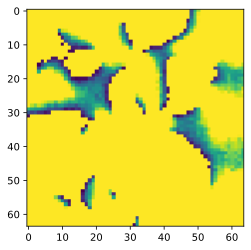

In [4]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread('spin_7.png') 
  
# Output Images 
plt.imshow(img) 

In [29]:
img.min()

0.0

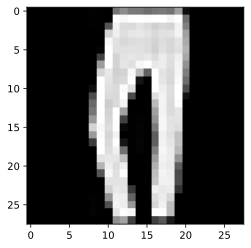

In [4]:
plt.imshow(Xtrain[2002].numpy().reshape(28,28) , matplotlib.pyplot.cm.gray)



A a first overview of the dataset, we can do a PCA (in 2D) of the training set. The following image represents the result: 

<img src="https://allauzen.github.io/assets/figs/pca-fashion-10-classes.png" 
    style="width:400px; margin:0px auto;display:block">



# Feed forward neural network



A feedforward model can rely on the pytorch module *Sequential*. 
A *Sequential* module is a container of ordered modules: the first one takes input data and its output is given to feed the second module, and so on. 

**Note: ** In pytorch, modules assumed Tensors as input. The input Tensor can contain just one input (online mode) or several inputs (mini-batch). The first dimension of the input Tensor corresponds to the mini-batch, and the second one to the dimension of the example to feed in. For example, with a mini-batch of size B and an image of D pixels, the input Tensor should be of shape (B,D), event if B=1. 


## Shallow network

Let start with a simple model with one input layer and one output layer (without hidden layers). Please refer to the examples provided previously, and propose an implementation of this linear model using the *Sequential* module as container.  To write the model, we must consider the fact that the model is trained in order to maximize the Log-likelihood on the training data. If you look at  https://pytorch.org/docs/stable/nn.html, the documentation of the NNet package of pytorch, there is a section on the loss functions. 

Two of the proposed loss function can be used for our purpose. The choice of one of them implies the choice of the activation function at the output layer. 

- What are these two possible choices ? 


==> NLL and softmax ? ou Cross Entropy  ?


Make your own choice and then fill the following code:



In [6]:
D_in = 784
D_out= 10

## 
model = nn.Sequential(
        nn.Linear(D_in,D_out),
        nn.LogSoftmax(dim=1) #on lui donne un tenseur et il normalise se
    )
loss_function = nn.NLLLoss()


Ci dessus : X(image) ==> a= W@X + b (avec W:784x10 et b:10)

Or P(y/x)= exp(ay)/Somme(exp(ay')) ==> on prend le log de ca

Si on connait c, on veux minimiser "-log(P(y=c/x)" C'est bien la NLL qu'on veut prendre.

En effet : la NLL prend en entrée (log proba, réponse)


Then test the code on a minibatch of B examples. The code below corresponds to a prediction on a single image and then on 3 images. Look at the results, their shapes and values. Is it consistent with what you expect ? 

In [7]:
B=1
i = 0
pred = model(Xtrain[i:i+B])
# explore 
print(pred)
B=3
i = 0
pred = model(Xtrain[i:i+B])
print(pred)

tensor([[-124.2594, -247.7910,  -29.7163,  -71.1753, -106.8237, -213.3296,
         -163.6124,  -75.4278,    0.0000,  -72.1699]],
       grad_fn=<LogSoftmaxBackward>)
tensor([[-1.2426e+02, -2.4779e+02, -2.9716e+01, -7.1175e+01, -1.0682e+02,
         -2.1333e+02, -1.6361e+02, -7.5428e+01,  0.0000e+00, -7.2170e+01],
        [-6.6870e+01, -2.1356e+02, -1.0997e+01, -1.4087e+02, -1.3480e+02,
         -1.6444e+02, -2.4682e+02, -1.6845e+02, -8.9963e+00, -1.4066e-04],
        [-6.2316e+01, -1.0165e+02, -8.2715e+01, -3.6401e+01, -4.7098e+01,
         -5.9436e+01, -1.0861e+02, -7.9785e+01, -4.7994e+01,  0.0000e+00]],
       grad_fn=<LogSoftmaxBackward>)


Do the same with the loss function. 

In [18]:
pred.shape

torch.Size([1, 10])

In [22]:
B=1
i = 1
pred = model(Xtrain[i:i+B])
loss = loss_function(pred,Ytrain[i:i+B]) 
print(loss)
# explore 
B=3
i = 1
pred = model(Xtrain[i:i+B])
loss = loss_function(pred,Ytrain[i:i+B]) 
print(loss)

tensor(66.8696, grad_fn=<NllLossBackward>)
tensor(59.0389, grad_fn=<NllLossBackward>)


## Online learning  and mini-batch

We will use the Adam optimizer with an initial learning rate of 0.001. Read, modify the following code. 



In [35]:
A=np.arange(9)
np.random.shuffle(A)
print(A)

[0 6 7 4 1 2 5 3 8]


In [23]:
from tqdm import tqdm

In [38]:
epochs=30

### The model, the loss and optimizer
model=nn.Sequential(nn.Linear(D_in,D_out),
                    nn.LogSoftmax(dim=1))
optimizer=th.optim.Adam(model.parameters(),lr=0.001) #ADAM = ADAptative Moment estimation
loss_fn=nn.NLLLoss()

### Mini-batching and shuffle 
Ntrain = Xtrain.shape[0]
Nvalid = Xvalid.shape[0]
print(Ntrain,Nvalid)
idx = np.arange(Ntrain)
batch_size = 200 # Beaucoup plus rapide que 1 ! 
nbatch = int(Ntrain/batch_size)
print(batch_size, nbatch)




train_losses,valid_losses, valid_accuracies=[],[],[]
 

for e in range(epochs):
    np.random.shuffle(idx)
    running_loss=0
    totaln = 0
    for bi in range(nbatch): #on calcule la loss sur un gros paquet d'images !
        ids = idx[bi*batch_size:(bi+1)*batch_size]
        images = Xtrain[ids]
        labels = Ytrain[ids]
        totaln += labels.shape[0] # the number of samples
        optimizer.zero_grad()
        logprobs=model(images)
        loss=loss_fn(logprobs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    # training is over for one epoch
    # now compute interesting quantities
    accuracy=0
    valid_loss = 0        
    with th.no_grad(): #on test le model sur le set de VALIDITE
        images = Xvalid
        labels = Yvalid
        logprobs=model(images)
        valid_loss=loss_fn(logprobs,labels)
        top_p,top_class=logprobs.topk(1)
        accuracy=(top_class.T == labels).sum().float()
    train_losses.append(running_loss/nbatch)
    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy.item()*100.0/Nvalid)
    print("Epoch: {}\t".format(e+1),
              "train Loss: {:.5f}.. ".format(train_losses[-1]),
              "valid Loss: {:.5f}.. ".format(valid_losses[-1]),
              "valid Accuracy: {:.3f}".format(valid_accuracies[-1]))  
print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch " 
      , np.fromiter(valid_accuracies, dtype=np.float).argmax(), " / ",epochs )


20000 10000
200 100
Epoch: 1	 train Loss: 12.46595..  valid Loss: 5.96582..  valid Accuracy: 75.090
Epoch: 2	 train Loss: 5.59112..  valid Loss: 6.39300..  valid Accuracy: 70.900
Epoch: 3	 train Loss: 4.71879..  valid Loss: 4.74884..  valid Accuracy: 77.320
Epoch: 4	 train Loss: 4.18714..  valid Loss: 4.34140..  valid Accuracy: 78.800
Epoch: 5	 train Loss: 3.57056..  valid Loss: 4.68725..  valid Accuracy: 77.120
Epoch: 6	 train Loss: 3.57000..  valid Loss: 4.20626..  valid Accuracy: 77.230
Epoch: 7	 train Loss: 3.48318..  valid Loss: 3.69503..  valid Accuracy: 80.790
Epoch: 8	 train Loss: 3.35719..  valid Loss: 4.42519..  valid Accuracy: 78.030
Epoch: 9	 train Loss: 2.94758..  valid Loss: 3.69057..  valid Accuracy: 79.580
Epoch: 10	 train Loss: 3.07253..  valid Loss: 3.54846..  valid Accuracy: 79.830
Epoch: 11	 train Loss: 2.61723..  valid Loss: 3.46707..  valid Accuracy: 79.560
Epoch: 12	 train Loss: 2.57646..  valid Loss: 4.09837..  valid Accuracy: 78.290
Epoch: 13	 train Loss: 2.751

Run the training loop with a batch size of 1 and then of size 200. The difference in terms of computation time should be significant ! We will now only use a batch size of 200. 

Note that in practice, the learning rate should be adapted to the mini-batch size. 

Run the previous training code with a batch size of 200 for 30 epochs. We can plot at the results like this


(0.0, 83.164)

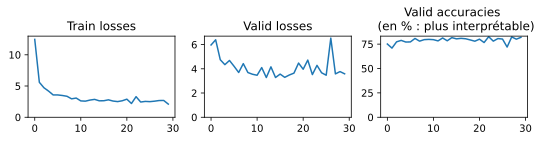

In [44]:
plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Train losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 2)
plt.plot(valid_losses)
plt.title('Valid losses')

ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 3)
plt.plot(valid_accuracies)
plt.title('Valid accuracies \n (en % : plus interprétable)')

ax.set_ylim(bottom=0)

La train loss se stabilise, la validité sur le set de validité stagne, et devrait même remonter.

Valid accuracies nous dit ici qu'on a à peu près 75% de chance d'avoir raison sur le set

## Training wrapper 

Write a function that wraps what we need to train a model and look at the results. Test it with a new model. 

Good to notice : the call of  *model(X)* return a 2D tensor. The 2D tensor has a line for every image of the batch. The line of an image has one column per label (here 10). The tensor contains the log-probabilities that the image corresponds to the label of the
column.


20000 10000
200 100
---------- Best : 81.660  at epoch  28  /  30


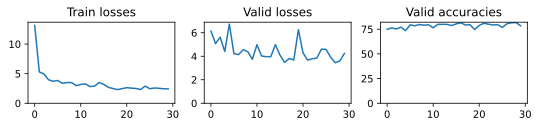

In [81]:
def train(model, epochs=30,verbose=False):
    # The verbose allows you to skip printed information per epoch.
    # The function will only print the best accuracy on the validation
    # and plot the learning curves. 
    
    ### Mini-batching and shuffle 
    Ntrain = Xtrain.shape[0]
    Nvalid = Xvalid.shape[0]
    print(Ntrain,Nvalid)
    idx = np.arange(Ntrain)
    batch_size = 200 # Beaucoup plus rapide que 1 ! 
    nbatch = int(Ntrain/batch_size)
    print(batch_size, nbatch)


    train_losses,valid_losses, valid_accuracies=[],[],[]


    for e in range(epochs):
        np.random.shuffle(idx)
        running_loss=0
        totaln = 0
        for bi in range(nbatch): #on calcule la loss sur un gros paquet d'images !
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            images = Xtrain[ids]
            labels = Ytrain[ids]
            totaln += labels.shape[0] # the number of samples
            optimizer.zero_grad()
            logprobs=model(images)
            loss=loss_fn(logprobs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        # training is over for one epoch
        # now compute interesting quantities
        accuracy=0
        valid_loss = 0        
        with th.no_grad(): # On est plus entrain d'apprendre, plus de gradient
            model.eval()
            images = Xvalid
            labels = Yvalid
            logprobs=model(images)
            valid_loss=loss_fn(logprobs,labels)
            top_p,top_class=logprobs.topk(1)
            accuracy=(top_class.T == labels).sum().float()
        model.train()
        train_losses.append(running_loss/nbatch)
        valid_losses.append(valid_loss)
        valid_accuracies.append(accuracy.item()*100.0/Nvalid)
        '''
        print("Epoch: {}\t".format(e+1),
                  "train Loss: {:.5f}.. ".format(train_losses[-1]),
                  "valid Loss: {:.5f}.. ".format(valid_losses[-1]),
                  "valid Accuracy: {:.3f}".format(valid_accuracies[-1])) 
        '''
    print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch " 
          , np.fromiter(valid_accuracies, dtype=np.float).argmax(), " / ",epochs )
    
    plt.figure(figsize = (9, 1.5))
    ax= plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Train losses')
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 3, 2)
    plt.plot(valid_losses)
    plt.title('Valid losses')
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 3, 3)
    plt.plot(valid_accuracies)
    plt.title('Valid accuracies')
    ax.set_ylim(bottom=0)
    
    return



# When we create the model, its parameters are initialized. 
model=nn.Sequential(nn.Linear(D_in,D_out),
                    nn.LogSoftmax(dim=1))
optimizer=th.optim.Adam(model.parameters(),lr=0.001)
# Note this important to build a new optimizer 
# if we want to have the reference to parameters 
# of the new model ! 
train(model)

# Neural Network with one hidden layer

Now we have a function to train and evaluate the training process of a neural model, we can explore different configurations. Let start with a neural network with one hidden layer and a Sigmoid activation function on this hidden layer. We set the size of this hidden layer to 50. 

Write the model using the Sequential module, and train it: 
- for 30 epochs and with lr=0.001 and lr=0.0001
- do the same and raise the number of epoch to 50
What do you observe ? 

**Rq**: il faut toujours ajouter une transformation non lineaire (Sigmoid par expl) entre les couches (entre W1 et W2). Sinon on ne ferait que appliquer deux transformations linéaires W2(W1(x))

20000 10000
200 100
---------- Best : 80.400  at epoch  48  /  50
20000 10000
200 100
---------- Best : 84.640  at epoch  48  /  50


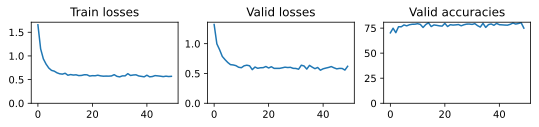

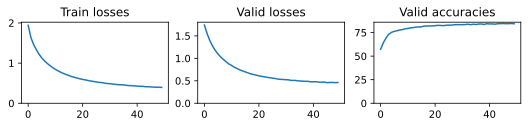

In [142]:
## TODO 
hidden_layer = 50 
D_in = 784
D_out= 10

model = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.Sigmoid(),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model.parameters(),lr=0.001) #mieux que 0.0001 (converge plus vite)

train(model,50,True)

model = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.Sigmoid(),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model.parameters(),lr=0.0001) #mieux que 0.0001 (converge plus vite)

train(model,50,True)



**Pas d'apprentissage** Pas d'apprentissage plus bas : il avance plus lentement mais de manière plus fiable. Avec un learning rate plus grand, quand on arrive au niveau du puit, on risque d'osciller et de ne pas descendre aussi bas qu'avec un pas plus petit.

### From Sigmoid to ReLU

**RQ cours** : la dérivée de la sigmoid est éclatée (gaussienne centrée en 0) : si le signal de sortie s'écarte un peu de 0 (genre il a une proba de 75%), le modèle apprend bcp moins pour lui que pour un point qui a une proba de 50%

C'est pour ca qu'on utilise la ReLU

Consider lr=0.0001 and train a similar model with a ReLU activation. Compare the results. 

20000 10000
200 100
---------- Best : 84.040  at epoch  46  /  50
20000 10000
200 100
---------- Best : 84.840  at epoch  45  /  50


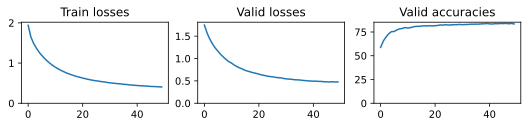

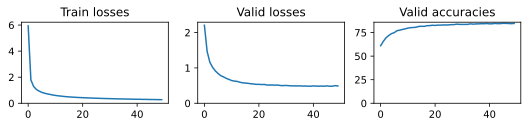

In [143]:
model = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.Sigmoid(),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model.parameters(),lr=0.0001) #mieux que 0.0001 (converge plus vite)

train(model,50,True)



hidden_layer = 50 
D_in = 784
D_out= 10

model_ReLU = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model_ReLU.parameters(),lr=0.0001)

train(model_ReLU,50,False)

### Impact of the hidden layer size

Run experiments with different hidden layer size, respectively : 50,100,150, 200 and 250. 
What do you observe ? 


20000 10000
200 100
---------- Best : 83.560  at epoch  28  /  30
20000 10000
200 100
---------- Best : 84.940  at epoch  28  /  30


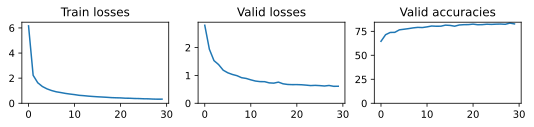

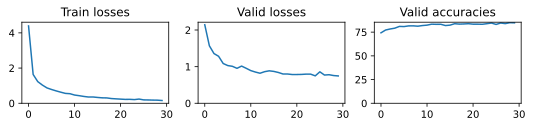

In [145]:
hidden_layer = 50
D_in = 784
D_out= 10

model_50 = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model_50.parameters(),lr=0.0001)

train(model_50,30,False)

hidden_layer = 200
D_in = 784
D_out= 10

model_200 = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model_200.parameters(),lr=0.0001)

train(model_200,30,False)


**Réponse** : Ca change rien en terme de validité d'avoir 200 neurones (ca converge plus vite mais on augmente la complexité), 50 c'est très bien, ca converge plus vite que 20 en plus

# Deeper network : 2 couches mieux que 1 ? Surapprentissage !

Now we add one more hidden layer and consider a NNet with two hidden layers. 
The first setup is: 
- two hidden layers of size 50 with a ReLU activation
- a learning rate of 0.0001

Train it during 100 epochs 

20000 10000
200 100
---------- Best : 85.800  at epoch  96  /  100
20000 10000
200 100
---------- Best : 86.510  at epoch  79  /  100


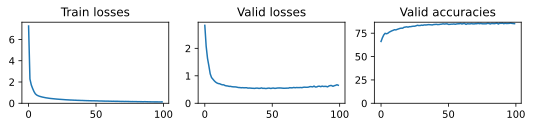

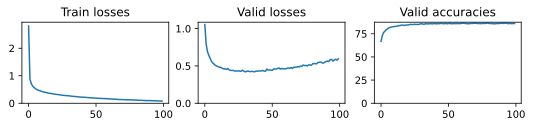

In [148]:
# 1 COUCHE
hidden_layer = 50
D_in = 784
D_out= 10

model = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)

train(model,100,False)


#DEUX COUCHES : 

hidden_layer = 50
D_in = 784
D_out= 10

model = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Linear(hidden_layer,hidden_layer),
    th.nn.ReLU(),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)

train(model,100,False)

On voit que la valid losses recroit : surapprentissage

Le dropout permet d'eviter le surapprentissage


## Dropout : 0.3 mieux que 0.5 !

You should observe overfitting, one solution is to add a dropout layer to the model (with a probability of 0.2 for example). Code this modification and rerun the training process to observe the impact. When you use a Dropout layer, the layer acts differently in the train mode and evaluation mode. You should take this into account when you train the model end when you compute the performance on the validation set. 



20000 10000
200 100
---------- Best : 86.710  at epoch  54  /  100
20000 10000
200 100
---------- Best : 83.430  at epoch  96  /  100


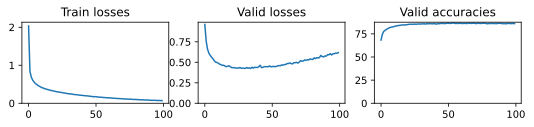

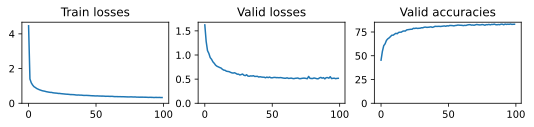

In [147]:
#SANS DROPOUT 
hidden_layer = 50
D_in = 784
D_out= 10

model = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Linear(hidden_layer,hidden_layer),
    th.nn.ReLU(),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)

train(model,100,False)


# AVEC DROPOUT
hidden_layer = 50
D_in = 784
D_out= 10


model_dropout = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(p=0.3),
    th.nn.Linear(hidden_layer,hidden_layer),
    th.nn.ReLU(),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model_dropout.parameters(),lr=0.0001)

train(model_dropout,100)

Try different value of dropout to assess its impact on the training process. For example 0.3 and 0.5. 

20000 10000
200 100
---------- Best : 79.650  at epoch  94  /  100
20000 10000
200 100
---------- Best : 63.240  at epoch  98  /  100


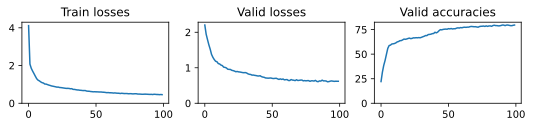

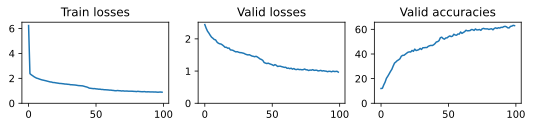

In [152]:
# 0.3
hidden_layer = 50
D_in = 784
D_out= 10

model_best = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model_best.parameters(),lr=0.0001)

train(model_best,100)



# 0.5

hidden_layer = 50
D_in = 784
D_out= 10

model_best = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.5),
    th.nn.Linear(hidden_layer,hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.5),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model_best.parameters(),lr=0.0001)

train(model_best,100)

Then you can play with different  "hyper-parameters":
- Increase the size (double for example) of the first hidden layer
- Add a third hidden layer. 


## Double first hidden layer size : mieux ?

20000 10000
200 100
---------- Best : 84.070  at epoch  97  /  100
20000 10000
200 100
---------- Best : 85.760  at epoch  76  /  100


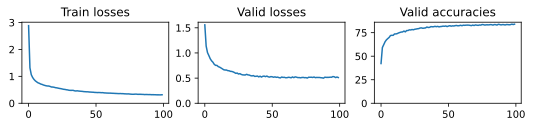

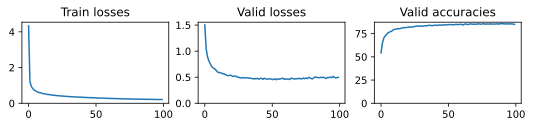

In [150]:
# SAME HIDDEN LAYER SIZE
hidden_layer = 50
D_in = 784
D_out= 10

model_best = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model_best.parameters(),lr=0.0001)

train(model_best,100)


# DOUBLE HIDDEN LAYER SIZE
hidden_layer = 50
D_in = 784
D_out= 10

model = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer*2),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer*2,hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)

train(model,100)

## Add a third layer

20000 10000
200 100
---------- Best : 80.930  at epoch  99  /  100
20000 10000
200 100
---------- Best : 80.220  at epoch  95  /  100
20000 10000
200 100
---------- Best : 82.040  at epoch  99  /  100


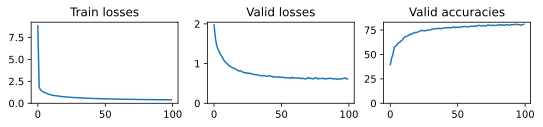

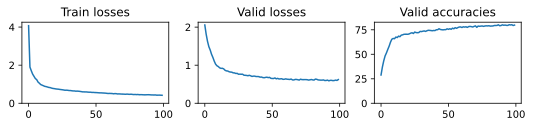

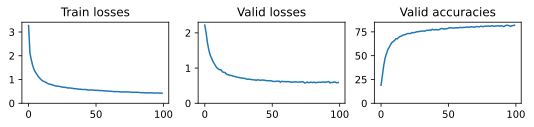

In [153]:
# 1 COUCHE
hidden_layer = 50
D_in = 784
D_out= 10

model = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model.parameters(),lr=0.0001)

train(model,100)

# 2 COUCHES

hidden_layer = 50
D_in = 784
D_out= 10

model_best = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model_best.parameters(),lr=0.0001)

train(model_best,100)

# 3 COUCHES

hidden_layer = 50
D_in = 784
D_out= 10

model3 = th.nn.Sequential(
    th.nn.Linear(D_in, hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,hidden_layer),
    th.nn.ReLU(),
    th.nn.Dropout(0.3),
    th.nn.Linear(hidden_layer,D_out),
    nn.LogSoftmax(dim=1)
)
optimizer=th.optim.Adam(model3.parameters(),lr=0.0001)

train(model3,100)

# Confusion matrix

For a good model you obtained, compute the confusion matrix and look at it. 


In [95]:
import sklearn
from sklearn.metrics import confusion_matrix

In [126]:
np.argmax(max(PRED[9]))

0

In [127]:
th.max(pred,1)

torch.return_types.max(
values=tensor([-1.1312e-04, -8.8000e-01, -1.1534e-01, -5.5738e-01, -8.7974e-04,
        -1.9129e-03, -8.0963e-01,  0.0000e+00,  0.0000e+00, -5.5059e-01],
       grad_fn=<MaxBackward0>),
indices=tensor([0, 6, 3, 3, 2, 7, 2, 5, 5, 0]))

Chaque objet a 10 probas. La meilleure d'entre elles correspond à la classe la plus probable.

Pour generer la matrice de confusion, il faut donc associer une classe à chaque objet, et la comparer à sa classe réelle (dans Ytrain)

In [187]:
B=1000
i = 1
model_best.eval()
pred = model_best(Xvalid[i:i+B])
Ymax=th.max(pred,1)

Indice_max_pred=Ymax[1]

Y=Yvalid[i:i+B]

CM=sklearn.metrics.confusion_matrix(Indice_max_pred,Y)

model_best.train()

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=50, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)

In [188]:
CM

array([[ 80,   0,   0,   3,   0,   0,  12,   0,   0,   0],
       [  0, 108,   0,   2,   1,   0,   0,   0,   0,   0],
       [  1,   4,  75,   0,  20,   0,  15,   0,   0,   0],
       [  4,   0,   2,  93,   5,   0,   5,   0,   0,   0],
       [  0,   0,  11,   5,  78,   0,  13,   0,   0,   0],
       [  0,   0,   0,   0,   0, 100,   0,   3,   1,   1],
       [ 11,   0,   4,   0,  12,   0,  58,   0,   1,   0],
       [  1,   0,   0,   0,   0,   4,   0,  92,   0,   9],
       [  1,   0,   0,   0,   0,   0,   1,   0,  87,   0],
       [  0,   0,   0,   0,   0,   1,   0,   2,   0,  74]], dtype=int64)

# PCA 

To analyse the results, beyond the confusion matrix, we can compute the PCA (in 2D) and plot the projected datapoints depending on their classes, for instance by considering every pairs of classes. To compute the PCA and project the data, we can use the implementation provided by sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). 

In [ ]:
# compute the PCA in 2D
from sklearn.decomposition import PCA
#  .... 


# Test 
Take two best models (with one and two hidden layers) and run the evaluation on the test set. 